# Motivation

In the MLP implementation of n-gram model, as n increases - out input layer size increases and then, we are squashing too much information from the input layer to the hidden layer, hence, we want to solve this problem - by making a deeper model which progressively fuses information to make its guess about the next character in the sequence.

We are going to arrive at something very similar to what [WaveNet](https://arxiv.org/pdf/1609.03499) paper has done.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt #for making figures
%matplotlib inline

In [23]:
#read all words 
words = open('names.txt','r').read().split('\n')
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [17]:
#build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
ctoi = {ch:i+1 for i,ch in enumerate(chars)}
ctoi['.'] = 0
ctoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [20]:
itoc = {i:ch for ch,i in ctoi.items()}
vocab_size = len(itoc)
print(itoc)
print(ctoi)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
27


In [21]:
#Shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [38]:
#DATASET BUILDING
block_size = 3 #context length: how many characters do we take to predict the next one

def build_dataset(words):
    X = []
    Y = []
    X_ctoi = []
    Y_ctoi = []
    for word in words:
        word += '.'
        for i in range(len(word)-block_size):
            x = word[i:i+block_size]
            y = word[i+block_size]
            x_ctoi = [ctoi[ch] for ch in x]
            y_ctoi = ctoi[y]
            X.append(x)
            Y.append(y)
            X_ctoi.append(x_ctoi)
            Y_ctoi.append(y_ctoi)
            
    return X, Y, X_ctoi, Y_ctoi

X, y, X_ctoi, y_ctoi = build_dataset(words)

print(X[0:5])
print(y[0:5])
print(X_ctoi[0:5])
print(y_ctoi[0:5])
print(len(X), len(y))

X_final = torch.tensor(X_ctoi)
y_final = torch.tensor(y_ctoi)

print(X_final)
print(y_final)

print(X_final.shape)
print(y_final.shape)

['emm', 'mma', 'oli', 'liv', 'ivi']
['a', '.', 'v', 'i', 'a']
[[5, 13, 13], [13, 13, 1], [15, 12, 9], [12, 9, 22], [9, 22, 9]]
[1, 0, 22, 9, 1]
132047 132047
tensor([[ 5, 13, 13],
        [13, 13,  1],
        [15, 12,  9],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])
tensor([ 1,  0, 22,  ..., 26, 24,  0])
torch.Size([132047, 3])
torch.Size([132047])


In [35]:
def build_dataset2(words):
    X = []
    Y = []
    X_ctoi = []
    Y_ctoi = []
    for word in words:
        for i in range(len(word)-block_size):
            x = word[i:i+block_size]
            y = word[i+block_size]
            x_ctoi = [ctoi[ch] for ch in x]
            y_ctoi = ctoi[y]
            X.append(x)
            Y.append(y)
            X_ctoi.append(x_ctoi)
            Y_ctoi.append(y_ctoi)
    X_final = torch.tensor(X_ctoi)
    Y_final = torch.tensor(Y_ctoi)
    print(X_final.shape, Y_final.shape)
    return X_final, Y_final

n1 = int(0.8 * (len(words)))
n2 = int(0.9 * (len(words)))
Xtr, Ytr = build_dataset2(words[:n1])
Xdev, Ydev = build_dataset2(words[n1:n2])
Xte, Yte = build_dataset2(words[n2:])

torch.Size([80322, 3]) torch.Size([80322])
torch.Size([9829, 3]) torch.Size([9829])
torch.Size([9928, 3]) torch.Size([9928])


In [40]:
def build_dataset2(words):
    X = []
    Y = []
    X_ctoi = []
    Y_ctoi = []
    for word in words:
        word += '.'
        for i in range(len(word)-block_size):
            x = word[i:i+block_size]
            y = word[i+block_size]
            x_ctoi = [ctoi[ch] for ch in x]
            y_ctoi = ctoi[y]
            X.append(x)
            Y.append(y)
            X_ctoi.append(x_ctoi)
            Y_ctoi.append(y_ctoi)
    X_final = torch.tensor(X_ctoi)
    Y_final = torch.tensor(Y_ctoi)
    print(X_final.shape, Y_final.shape)
    return X_final, Y_final

n1 = int(0.8 * (len(words)))
n2 = int(0.9 * (len(words)))
Xtr, Ytr = build_dataset2(words[:n1])
Xdev, Ydev = build_dataset2(words[n1:n2])
Xte, Yte = build_dataset2(words[n2:])

torch.Size([105900, 3]) torch.Size([105900])
torch.Size([13024, 3]) torch.Size([13024])
torch.Size([13123, 3]) torch.Size([13123])


In [41]:
def build_dataset2(words):
    X = []
    Y = []
    X_ctoi = []
    Y_ctoi = []
    for word in words:
        word += '.'
        mod_word = '...'
        word = mod_word + word
        for i in range(len(word)-block_size):
            x = word[i:i+block_size]
            y = word[i+block_size]
            x_ctoi = [ctoi[ch] for ch in x]
            y_ctoi = ctoi[y]
            X.append(x)
            Y.append(y)
            X_ctoi.append(x_ctoi)
            Y_ctoi.append(y_ctoi)
    X_final = torch.tensor(X_ctoi)
    Y_final = torch.tensor(Y_ctoi)
    print(X_final.shape, Y_final.shape)
    return X_final, Y_final

n1 = int(0.8 * (len(words)))
n2 = int(0.9 * (len(words)))
Xtr, Ytr = build_dataset2(words[:n1])
Xdev, Ydev = build_dataset2(words[n1:n2])
Xte, Yte = build_dataset2(words[n2:])

torch.Size([182778, 3]) torch.Size([182778])
torch.Size([22633, 3]) torch.Size([22633])
torch.Size([22735, 3]) torch.Size([22735])


In [46]:
#Near copy paste of the layers we have developed in Part 3

#--------------------------------------------------------------------------
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 #note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

#-------------------------------------------------------------------------

class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters (trained with backprop)
        self.gamma = torch.ones(dim) #Scaling factor
        self.beta = torch.zeros(dim) #Bias factor
        #buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #if calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean)/torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
    
    def eval():
        self.training = False

'''
In the previous lecture, we developed this crazy layer,
and what's particularly interesting about it is a few things.

First, it has running mean and variance values that are trained
outside of backpropagation, using exponential moving averages
during the forward pass.

Additionally, there's a training flag because the behavior
of batch normalization changes between training and evaluation,
so we need to ensure it's in the correct state—
either training or evaluation.

This often introduces bugs if you forget to set it properly.
We also saw that batch normalization couples the activations
across examples in the batch, which is unusual because
we typically think of the batch as just an efficiency mechanism.

But now, the computation is linked across batch elements
to control the normalization statistics.

This layer is quite weird and prone to bugs, partly because
of the need to handle the training and evaluation phases,
and also because you have to wait for the mean and variance
to stabilize.

Essentially, there's state in this layer, and state is usually harmful.
'''

#---------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

#---------------------------------------------------------------------

In [44]:
torch.manual_seed(42); #seed rng for reproducibility

In [47]:
n_embd = 10 #the dimensionality of the character embedding vectors
n_hidden = 200 #the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd))

layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), 
]

#parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 #last layer make less confident

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) #number of parameters in total

for p in parameters:
    p.requires_grad = True

12097


In [48]:
epochs = 10
batch_size = 32

In [51]:
ix = torch.randint(0, len(Xtr), (batch_size,))
ix

tensor([  5149, 121964, 174301, 154588, 168034, 146410, 102788, 120467,   7420,
         22697,  14203,   8175,  92358, 143009,  11684,  59881,  25464, 145732,
         69788,     30, 132377, 164919, 172956,  36607, 131016, 105862,  73349,
         49862,  34192,  21362,  18946, 120716])

In [68]:
epochs = 200000
batch_size = 32
lossi = []

for i in range(epochs):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb = Xtr[ix]
    yb = Ytr[ix]

    #forward pass
    emb = C[Xb] #(32, 3, 10)
    x = emb.view(emb.shape[0], -1) #concatenate the embedding vectors for each character in a sample
    # (32, 30)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update: simple SGD
    lr = 0.1 if i < 150000 else 0.01 #step learning rate decay
    for p in parameters:
            p.data += -lr * p.grad

    #track stats
    if i%10000 == 0: #print every once in a while
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 2.0055
  10000/ 200000: 2.3014
  20000/ 200000: 2.3613
  30000/ 200000: 2.2689
  40000/ 200000: 1.9782
  50000/ 200000: 2.1387
  60000/ 200000: 1.8741
  70000/ 200000: 2.4214
  80000/ 200000: 1.9898
  90000/ 200000: 1.5678
 100000/ 200000: 1.8242
 110000/ 200000: 2.2046
 120000/ 200000: 2.0124
 130000/ 200000: 2.1698
 140000/ 200000: 2.4924
 150000/ 200000: 1.9992
 160000/ 200000: 1.8935
 170000/ 200000: 2.1948
 180000/ 200000: 1.9832
 190000/ 200000: 1.8950


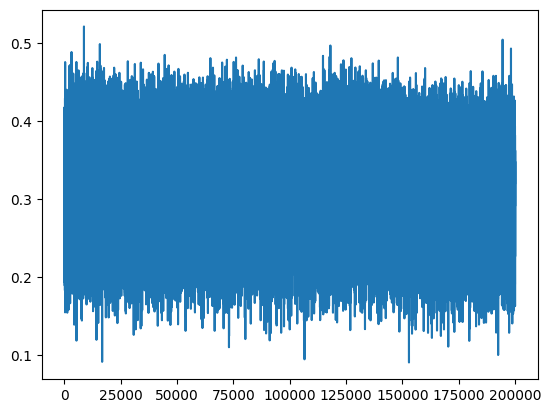

In [69]:
plt.plot(lossi)

In [70]:
#put layers into eval mode (needed for batchnorm especially)
for layer in layers:
    layer.training = False


In [86]:
#evaluate the loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] #(N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
    

train 1.994327425956726
val 2.306034564971924


In [80]:
#sample from model

for _ in range(20):#want to generate 20 samples

    out = []
    context = [0] * block_size #initialize with all ...
    while True:
        #forward pass the neural net
        emb = C[torch.tensor(context).view(1, block_size, -1)] #(1, block_size, n_embd)
        #print(emb.shape)
        #Above is embedding operation
        x = emb.view(emb.shape[0], -1) #concatenate the vectors
        #This is flattening operation
        #print(x.shape)
        for layer in layers:
            #print(x.shape)
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        #sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()

        #shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        #if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itoc[i] for i in out))
        

neriden.
kava.
milee.
mehro.
lore.
tylee.
lia.
zuri.
mari.
truisaelah.
ziya.
malayna.
deyon.
karaidenri.
zuru.
laurtn.
semandreslin.
mber.
meleeyair.
farman.


ABOVE EVERYTHING WAS JUST A RECAP!<br>
Now, let's try to improve this with wavenet's dilated convolutions architecture!

### 1) First let's fix the loss plot, it doesn't look good!

We can aggregate some intial k losses with average and then plot such 200000/k values (since 200000 epochs are there)!

In [81]:
torch.tensor(lossi).view(-1, 1000).shape #Aggregating over first 1000 guys

torch.Size([200, 1000])

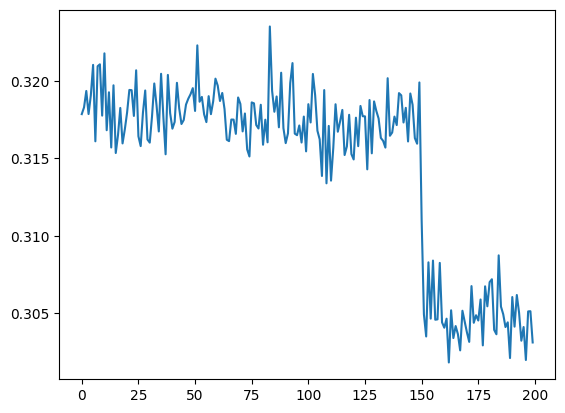

In [85]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1, keepdim=True))

### 2) Next, our Forward pass doesn't look that clean - the embeddings layer is explictly calculated in training pass, can we create an abstraction for it, to make things look cleaner?

In [104]:
#Near copy paste of the layers we have developed in Part 3

#--------------------------------------------------------------------------
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 #note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

#-------------------------------------------------------------------------

class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters (trained with backprop)
        self.gamma = torch.ones(dim) #Scaling factor
        self.beta = torch.zeros(dim) #Bias factor
        #buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #if calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean)/torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
    
    def eval():
        self.training = False

'''
In the previous lecture, we developed this crazy layer,
and what's particularly interesting about it is a few things.

First, it has running mean and variance values that are trained
outside of backpropagation, using exponential moving averages
during the forward pass.

Additionally, there's a training flag because the behavior
of batch normalization changes between training and evaluation,
so we need to ensure it's in the correct state—
either training or evaluation.

This often introduces bugs if you forget to set it properly.
We also saw that batch normalization couples the activations
across examples in the batch, which is unusual because
we typically think of the batch as just an efficiency mechanism.

But now, the computation is linked across batch elements
to control the normalization statistics.

This layer is quite weird and prone to bugs, partly because
of the need to handle the training and evaluation phases,
and also because you have to wait for the mean and variance
to stabilize.

Essentially, there's state in this layer, and state is usually harmful.
'''

#---------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

#---------------------------------------------------------------------

class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

#--------------------------------------------------------------------

class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []

In [98]:
torch.manual_seed(42); 

In [108]:
n_embd = 10 #the dimensionality  
n_hidden = 200 #the number of neurons in the hidden layer of the MLP

layers = [
    Embedding(vocab_size, n_embd),
    Flatten(),
    #Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_embd*block_size, n_hidden), Tanh(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

#parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 #last layer make less confident
parameters = [p for layer in layers for p in layer.parameters()]

#custom counting of parameters
i = 0
for p in parameters:
    temp = 1
    for j in p.shape:
        temp *= j
    i += temp
print(i)

#using in-built nelement() function
#print(sum(p.nelement() for p in layer.parameters() for layer in layers))
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12097
12097


In [109]:
epochs = 200000
batch_size = 32
lossi = []

for i in range(epochs):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb = Xtr[ix]
    yb = Ytr[ix]

    #forward pass
    #emb = C[Xb] #(32, 3, 10)
    #x = emb.view(emb.shape[0], -1) #concatenate the embedding vectors for each character in a sample
    # (32, 30)
    #print(Xb.shape)
    x = Xb
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update: simple SGD
    lr = 0.1 if i < 150000 else 0.01 #step learning rate decay
    for p in parameters:
            p.data += -lr * p.grad

    #track stats
    if i%10000 == 0: #print every once in a while
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break

torch.Size([32, 3])
      0/ 200000: 3.2833


### 3) Let's PyTorchify this!

First let's implement Sequential layers functionality available in PyTorch, so that we can achieve even more abstraction over the explicit definition of layers as we did in last second cell!

In [186]:
#Near copy paste of the layers we have developed in Part 3

#--------------------------------------------------------------------------
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 #note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

#-------------------------------------------------------------------------

class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters (trained with backprop)
        self.gamma = torch.ones(dim) #Scaling factor
        self.beta = torch.zeros(dim) #Bias factor
        #buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #if calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean)/torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
    
    def eval():
        self.training = False

'''
In the previous lecture, we developed this crazy layer,
and what's particularly interesting about it is a few things.

First, it has running mean and variance values that are trained
outside of backpropagation, using exponential moving averages
during the forward pass.

Additionally, there's a training flag because the behavior
of batch normalization changes between training and evaluation,
so we need to ensure it's in the correct state—
either training or evaluation.

This often introduces bugs if you forget to set it properly.
We also saw that batch normalization couples the activations
across examples in the batch, which is unusual because
we typically think of the batch as just an efficiency mechanism.

But now, the computation is linked across batch elements
to control the normalization statistics.

This layer is quite weird and prone to bugs, partly because
of the need to handle the training and evaluation phases,
and also because you have to wait for the mean and variance
to stabilize.

Essentially, there's state in this layer, and state is usually harmful.
'''

#---------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

#---------------------------------------------------------------------

class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

#--------------------------------------------------------------------

class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []

#--------------------------------------------------------------------

class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
        
    def parameters(self):
        #get parameter
        return [p for layer in self.layers for p in layer.parameters()]

In [187]:
torch.manual_seed(42)

In [188]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

#parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

####IMP STEP######
for p in parameters:
    p.requires_grad = True

12097


In [189]:
epochs = 200000
batch_size = 32
lossi = []

for i in range(epochs):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb = Xtr[ix]
    yb = Ytr[ix]

    #forward pass
    #emb = C[Xb] #(32, 3, 10)
    #x = emb.view(emb.shape[0], -1) #concatenate the embedding vectors for each character in a sample
    # (32, 30)
    #print(Xb.shape)
    #x = Xb
    #for layer in layers:
    #    x = layer(x)
    logits = model(Xb)
    loss = F.cross_entropy(logits, yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update: simple SGD
    lr = 0.1 if i < 150000 else 0.01 #step learning rate decay
    for p in parameters:
            p.data += -lr * p.grad

    #track stats
    if i%10000 == 0: #print every once in a while
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    #break

      0/ 200000: 3.3120
  10000/ 200000: 2.3087
  20000/ 200000: 2.4581
  30000/ 200000: 2.0248
  40000/ 200000: 2.0344
  50000/ 200000: 1.8438
  60000/ 200000: 2.3635
  70000/ 200000: 2.2314
  80000/ 200000: 2.0361
  90000/ 200000: 1.9515
 100000/ 200000: 1.7977
 110000/ 200000: 1.9117
 120000/ 200000: 1.9738
 130000/ 200000: 2.4556
 140000/ 200000: 1.9853
 150000/ 200000: 2.5439
 160000/ 200000: 2.1277
 170000/ 200000: 2.0401
 180000/ 200000: 2.1280
 190000/ 200000: 1.9346


In [190]:
#put layers into eval mode (needed for batchnorm especially)
#for layer in layers:
 #   layer.training = False

for layer in model.layers:
    layer.training = False

In [191]:
#evaluate the loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    #emb = C[x] #(N, block_size, n_embd)
    #x = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embd)
    #for layer in layers:
    #    x = layer(x)
    x = model(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0128419399261475
val 2.3205068111419678


In [192]:
#sample from model

for _ in range(20):#want to generate 20 samples

    out = []
    context = [0] * block_size #initialize with all ...
    while True:
        logits = model(torch.tensor(context).view(1,-1))
        #logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        #sample from the distribution
        #print(probs)
        ix = torch.multinomial(probs, num_samples=1).item()

        #shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        #if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itoc[i] for i in out))
        

damiara.
alyz.
aria.
tri.
gerrysha.
roy.
lorie.
rosso.
jesse.
catine.
air.
alitithira.
liza.
jamis.
anie.
daison.
alana.
lon.
quas.
tori.


The difference in train loss and val loss is signficant, so it looks like we have saturated our training potential with this architecture!<br>
What if we scale our network/architecture? - Introducing additional layers(making it more deep), more parameters (by increasing the n_embd, n_hidden, etc), __still the problem that we are crushing the n_emb * block_size values into a smaller hidden layer and causing information loss stays the same.__ <br>

This problem is addressed by the WaveNet paper and we would like our architecture to adapt that and look similar to following: <br>
![title](img/wavenet.png)

Before starting to implement this sort of architecture, let's bump our block_size to 8 and see, how well it performs - so that we have a baseline!

In [218]:
#Build the dataset
block_size = 8 #context length: how many characters do we take to predict the next one

def build_dataset3(words):
    X = []
    Y = []
    for word in words:
        eight_dots = '........'
        eight_dots += word
        word = eight_dots + '.'
        #print(word)
        for i in range(len(word) - block_size):
            x = word[i:i+block_size]
            y = word[i+block_size]
            print(x, y)
            x_ctoi = [ctoi[ch] for ch in x]
            y_ctoi = ctoi[y]
            X.append(x_ctoi)
            Y.append(y_ctoi)
    X_final = torch.tensor(X)
    Y_final = torch.tensor(Y)
    print(X_final.shape, Y_final.shape)
    return X_final, Y_final

X, Y = build_dataset3(words[0:5])
print(X)
print(Y)

........ e
.......e m
......em m
.....emm a
....emma .
........ o
.......o l
......ol i
.....oli v
....oliv i
...olivi a
..olivia .
........ a
.......a v
......av a
.....ava .
........ i
.......i s
......is a
.....isa b
....isab e
...isabe l
..isabel l
.isabell a
isabella .
........ s
.......s o
......so p
.....sop h
....soph i
...sophi a
..sophia .
torch.Size([32, 8]) torch.Size([32])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  5],
        [ 0,  0,  0,  0,  0,  0,  5, 13],
        [ 0,  0,  0,  0,  0,  5, 13, 13],
        [ 0,  0,  0,  0,  5, 13, 13,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 15],
        [ 0,  0,  0,  0,  0,  0, 15, 12],
        [ 0,  0,  0,  0,  0, 15, 12,  9],
        [ 0,  0,  0,  0, 15, 12,  9, 22],
        [ 0,  0,  0, 15, 12,  9, 22,  9],
        [ 0,  0, 15, 12,  9, 22,  9,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  0,  0,  0

In [217]:
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset3(words[:n1])
Xdev, Ydev = build_dataset3(words[n1:n2])
Xte, Yte = build_dataset3(words[n2:])

torch.Size([182778, 8]) torch.Size([182778])
torch.Size([22633, 8]) torch.Size([22633])
torch.Size([22735, 8]) torch.Size([22735])


In [219]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

#parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

####IMP STEP######
for p in parameters:
    p.requires_grad = True

22097


In [220]:
epochs = 200000
batch_size = 32
lossi = []

for i in range(epochs):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb = Xtr[ix]
    yb = Ytr[ix]

    #forward pass
    #emb = C[Xb] #(32, 3, 10)
    #x = emb.view(emb.shape[0], -1) #concatenate the embedding vectors for each character in a sample
    # (32, 30)
    #print(Xb.shape)
    #x = Xb
    #for layer in layers:
    #    x = layer(x)
    logits = model(Xb)
    loss = F.cross_entropy(logits, yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update: simple SGD
    lr = 0.1 if i < 150000 else 0.01 #step learning rate decay
    for p in parameters:
            p.data += -lr * p.grad

    #track stats
    if i%10000 == 0: #print every once in a while
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    #break

      0/ 200000: 3.3066
  10000/ 200000: 2.3373
  20000/ 200000: 1.8871
  30000/ 200000: 1.6485
  40000/ 200000: 2.2205
  50000/ 200000: 2.1845
  60000/ 200000: 1.9514
  70000/ 200000: 2.0674
  80000/ 200000: 1.6834
  90000/ 200000: 1.6009
 100000/ 200000: 2.3587
 110000/ 200000: 1.8234
 120000/ 200000: 2.2692
 130000/ 200000: 1.9086
 140000/ 200000: 1.7967
 150000/ 200000: 1.7759
 160000/ 200000: 1.9246
 170000/ 200000: 2.3713
 180000/ 200000: 1.7288
 190000/ 200000: 1.9491


In [221]:
for layer in model.layers:
    layer.training = False

In [222]:
#evaluate the loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    #emb = C[x] #(N, block_size, n_embd)
    #x = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embd)
    #for layer in layers:
    #    x = layer(x)
    x = model(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.8679134845733643
val 2.2466118335723877


### Performance Log:
* original(3 character context + 200 hidden neurons, 12K params): train 2.01, val: 2.3
* context: 3 -> 8 (22K params): train 1.86 and val 2.24

In [223]:
#sample from model

for _ in range(20):#want to generate 20 samples

    out = []
    context = [0] * block_size #initialize with all ...
    while True:
        logits = model(torch.tensor(context).view(1,-1))
        #logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        #sample from the distribution
        #print(probs)
        ix = torch.multinomial(probs, num_samples=1).item()

        #shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        #if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itoc[i] for i in out))
        

clyona.
fatyn.
rishaalun.
eliya.
layelle.
hirah.
joella.
myiah.
chiyah.
reinin.
emerilee.
niamtha.
j.
jazzabel.
avanni.
osette.
caynni.
wylin.
arleer.
bowie.


Let's try to see how we can implement a hierarchical scheme!

Before that, let's see how the shapes of the outputs of each layer look like with a small batch of examples say 4!

In [227]:
ix = torch.randint(0, Xtr.shape[0], (4,)) #let's look at a batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
print(Xb)
#print(logits)

torch.Size([4, 8])
tensor([[ 0,  0,  0,  0,  5, 13,  5, 18],
        [ 0,  0,  0,  0,  4,  1, 13,  1],
        [ 0,  0, 19, 20,  5, 22,  1, 14],
        [ 0,  0,  0,  0,  0,  0,  0, 13]])


In [228]:
model.layers[0].out.shape #output of embedding layer

torch.Size([4, 8, 10])

In [229]:
model.layers[1].out.shape #output of Flatten layer

torch.Size([4, 80])

In [230]:
model.layers[2].out.shape #output of Linear Layer

torch.Size([4, 200])

In [231]:
(torch.randn(4,80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])

In [232]:
(torch.randn(4,5,80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 5, 200])

Power of torch!!

In [233]:
(torch.randn(4,5,9,80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 5, 9, 200])

Rather than directly multiplying 80 input neurons corresponding to the 8 context blocks - we want to groups them two context elements into one like follows: <br>
1,2,3,4,5,6,7,8 <br>
#(1,2) (3, 4) (5,6) (7,8)<br>
Two context elements should get flattened out and multiplied by weight matrix. But we want to process these 4 in parallel! It's like a batch dimension we can introduce and process these bigram groups in the 4 batch dimensions of an individual sample and across actual dimension of the batches of samples!

In [234]:
#Original Linear layer implementation
(torch.randn(4,80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])

In [235]:
(torch.randn(4,4,20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

We would want our Output of first linear layer to look like above!

In [237]:
#How to access only even or odd neurons (alternate ones)

#Recollect

print(list(range(10))[1::2])

print(list(range(10))[::2])

[1, 3, 5, 7, 9]
[0, 2, 4, 6, 8]


In [240]:
#the embedding we have (4,8,10) we want it to be converted into 4, 4, 20 i.e. 1,2,3,4,5,6,7,8 --> (1,2), (3,4), (5,6), (7,8)

e = torch.randn(4,8,10) # goal : want this to be (4,4,20) where consecutive 10-d vectors get concatendated
explicit = torch.cat([e[:, ::2, :], e [:,1::2,:]], dim = 2)
explicit.shape

torch.Size([4, 4, 20])

In [242]:
(e.view(4,4,20) == explicit).all()

tensor(True)

Once, we are clear with this idea, let's go to Flatten layer and implement this!

In [245]:
#Near copy paste of the layers we have developed in Part 3

#--------------------------------------------------------------------------
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 #note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

#-------------------------------------------------------------------------

class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters (trained with backprop)
        self.gamma = torch.ones(dim) #Scaling factor
        self.beta = torch.zeros(dim) #Bias factor
        #buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #if calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean)/torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
    
    def eval():
        self.training = False

'''
In the previous lecture, we developed this crazy layer,
and what's particularly interesting about it is a few things.

First, it has running mean and variance values that are trained
outside of backpropagation, using exponential moving averages
during the forward pass.

Additionally, there's a training flag because the behavior
of batch normalization changes between training and evaluation,
so we need to ensure it's in the correct state—
either training or evaluation.

This often introduces bugs if you forget to set it properly.
We also saw that batch normalization couples the activations
across examples in the batch, which is unusual because
we typically think of the batch as just an efficiency mechanism.

But now, the computation is linked across batch elements
to control the normalization statistics.

This layer is quite weird and prone to bugs, partly because
of the need to handle the training and evaluation phases,
and also because you have to wait for the mean and variance
to stabilize.

Essentially, there's state in this layer, and state is usually harmful.
'''

#---------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

#---------------------------------------------------------------------

class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

#--------------------------------------------------------------------

class FlattenConsecutive:
    def __init__(self, n):#n denotes - the number of elements that are consecutive that we would like to concatenate now in the last dimension of the output flatten received
        self.n = n
        
    def __call__(self, x):
        B, T, C = x.shape#T is block size, B is batch size and C is the n_embd
        x = x.view(B, T//self.n, C*self.n)#What if T is not divisible by n? - We ensure that T is divisible by n, if T == n: then, T//n = 1 - he is calling it a spurrious dimension
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

#-----------------------------------------------------------------------

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []

#--------------------------------------------------------------------

class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
        
    def parameters(self):
        #get parameter
        return [p for layer in self.layers for p in layer.parameters()]

In [247]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(block_size),#FlattenConsecutive(8) is equivalent to Flatten()
    Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

#parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

####IMP STEP######
for p in parameters:
    p.requires_grad = True

22097


In [248]:
ix = torch.randint(0, Xtr.shape[0], (4,)) #let's look at a batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
print(Xb)

torch.Size([4, 8])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  7],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  1, 26,  1],
        [ 0,  0,  0, 10,  1, 19, 13, 25]])


In [250]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 80)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


As we have verified it, let's see the hierarchical thing in action now!

In [256]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2),Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

#parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

####IMP STEP######
for p in parameters:
    p.requires_grad = True

170897


In [257]:
ix = torch.randint(0, Xtr.shape[0], (4,)) #let's look at a batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
print(Xb)

torch.Size([4, 8])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 23,  1, 12],
        [ 0,  0,  0, 13,  5, 14,  4, 25],
        [ 0,  0,  0,  0, 13,  1, 14, 15]])


In [258]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [254]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2),Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),# WIll give error since, after squeeze happens, this won't work anymore
    Linear(n_hidden, vocab_size)
])

#parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

####IMP STEP######
for p in parameters:
    p.requires_grad = True

251297


In [255]:
ix = torch.randint(0, Xtr.shape[0], (4,)) #let's look at a batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
print(Xb)

ValueError: not enough values to unpack (expected 3, got 2)

In order to perform comparison - regarding how much improvement has FlattenConsecutive brought up compared to earlier model with block size = 8, we first should note that there we had 22K parameters, whereas here we are having 170K parameters currently, so we should choose such a n_hidden that the number of parameters between both architectures are comparable to do a fair comparison between their performances!<br>

With n_hidden = 68, we get comparable number of parameters (after trying out many values)

In [274]:
n_embd = 10
n_hidden = 68

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2),Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

#parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

####IMP STEP######
for p in parameters:
    p.requires_grad = True

22397


In [275]:
epochs = 200000
batch_size = 32
lossi = []

for i in range(epochs):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb = Xtr[ix]
    yb = Ytr[ix]

    logits = model(Xb)
    loss = F.cross_entropy(logits, yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update: simple SGD
    lr = 0.1 if i < 150000 else 0.01 #step learning rate decay
    for p in parameters:
            p.data += -lr * p.grad

    #track stats
    if i%10000 == 0: #print every once in a while
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.2940
  10000/ 200000: 2.1144
  20000/ 200000: 2.3360
  30000/ 200000: 1.9287
  40000/ 200000: 2.2959
  50000/ 200000: 1.9733
  60000/ 200000: 2.1553
  70000/ 200000: 2.3056
  80000/ 200000: 2.2075
  90000/ 200000: 1.9163
 100000/ 200000: 2.0340
 110000/ 200000: 1.6178
 120000/ 200000: 1.7981
 130000/ 200000: 1.5063
 140000/ 200000: 2.2363
 150000/ 200000: 1.9261
 160000/ 200000: 1.7227
 170000/ 200000: 1.8187
 180000/ 200000: 2.1663
 190000/ 200000: 1.9283


In [276]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


In [286]:
e = torch.randn(32, 4, 68)
emean = e.mean(0, keepdim=True) #1, 4, 68
evar = e.var(0, keepdim=True) #1, 4, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5) #32, 4, 68
ehat.shape

torch.Size([32, 4, 68])

In [287]:
emean.shape

torch.Size([1, 4, 68])

In [288]:
model.layers[3].running_mean.shape

torch.Size([1, 4, 68])

In [289]:
e = torch.randn(32, 4, 68)
emean = e.mean((0,1), keepdim=True) #1, 4, 68
evar = e.var((0,1), keepdim=True) #1, 4, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5) #32, 4, 68
ehat.shape

torch.Size([32, 4, 68])

In [290]:
emean.shape

torch.Size([1, 1, 68])

In [291]:
model.layers[3].running_mean.shape

torch.Size([1, 4, 68])

Andrej has given some sort of intuition on why the earlier batchnorm1d doesn't work well on our 3 dimensional inputs and then also introduced a fix to it (which I haven't completely understood)!<br>
We will first evaluate this model now and then, try to modify BatchNorm1d to work well for this!<br>

In [292]:
for layer in model.layers:
    layer.training = False

In [293]:
#evaluate the loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    #emb = C[x] #(N, block_size, n_embd)
    #x = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embd)
    #for layer in layers:
    #    x = layer(x)
    x = model(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.8917455673217773
val 2.2528269290924072


### Performance Log:
* original(3 character context + 200 hidden neurons, 12K params): train 2.01, val: 2.3
* context: 3 -> 8 (22K params): train 1.86 and val 2.24
* flat -> hierarchical(22K params): train 1.89 and val 2.25

In [294]:
#sample from model

for _ in range(20):#want to generate 20 samples

    out = []
    context = [0] * block_size #initialize with all ...
    while True:
        logits = model(torch.tensor(context).view(1,-1))
        #logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        #sample from the distribution
        #print(probs)
        ix = torch.multinomial(probs, num_samples=1).item()

        #shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        #if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itoc[i] for i in out))
        

jaymina.
jakari.
lubir.
matharie.
alaina.
daxtyn.
jennah.
frahleigh.
paite.
marlyndal.
olaria.
benty.
willah.
isvale.
kada.
tatur.
jeniise.
jaylynn.
adaia.
minsa.


Andrej got same results as the previous ones XD!!<br>
My run also gave me same validation loss and slightly worse train loss - Is this FlattenConsecutive good for nothing?<br>

He pointed that, we might not be using best configuration (i.e. doing proper allocation of the parameters across the mentioned layers)!<br>
He also pointed out that there might be a bug in BN layer! - Cuz it does run, but does it do the right thing?<br>
Since, we build it keeping in mind 2D tensors will be fed to it (n * d where, n is nth sample in batch and d is its dimension)<br>

In [295]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (1, 8, 10)
FlattenConsecutive : (1, 4, 20)
Linear : (1, 4, 68)
BatchNorm1d : (1, 4, 68)
Tanh : (1, 4, 68)
FlattenConsecutive : (1, 2, 136)
Linear : (1, 2, 68)
BatchNorm1d : (1, 2, 68)
Tanh : (1, 2, 68)
FlattenConsecutive : (1, 136)
Linear : (1, 68)
BatchNorm1d : (1, 68)
Tanh : (1, 68)
Linear : (1, 27)


In [296]:
#Near copy paste of the layers we have developed in Part 3

#--------------------------------------------------------------------------
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 #note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

#-------------------------------------------------------------------------

class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters (trained with backprop)
        self.gamma = torch.ones(dim) #Scaling factor
        self.beta = torch.zeros(dim) #Bias factor
        #buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #if calculate the forward pass
        if self.training:
            #MODIFICATION BEING APPLIED HERE - we are starting to depart from the PyTorch API of Batchnorm1d since, the input to it can be : N,C or N,C,L
            #where C is number of features and L is the sequence length so, technically only allowing 2 dim input - https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
            #PyTorch assumes that C will always assume dim = 1, here, in our implementation of FlattenConsecutive : We have also saw that the batch getting split over first 2 dims i.e.
            #N,L,C types input - which is where batchnorm1d won't work well
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
            #xmean = x.mean(0, keepdim=True)
            #xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean)/torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
    
    def eval():
        self.training = False

'''
In the previous lecture, we developed this crazy layer,
and what's particularly interesting about it is a few things.

First, it has running mean and variance values that are trained
outside of backpropagation, using exponential moving averages
during the forward pass.

Additionally, there's a training flag because the behavior
of batch normalization changes between training and evaluation,
so we need to ensure it's in the correct state—
either training or evaluation.

This often introduces bugs if you forget to set it properly.
We also saw that batch normalization couples the activations
across examples in the batch, which is unusual because
we typically think of the batch as just an efficiency mechanism.

But now, the computation is linked across batch elements
to control the normalization statistics.

This layer is quite weird and prone to bugs, partly because
of the need to handle the training and evaluation phases,
and also because you have to wait for the mean and variance
to stabilize.

Essentially, there's state in this layer, and state is usually harmful.
'''

#---------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

#---------------------------------------------------------------------

class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

#--------------------------------------------------------------------

class FlattenConsecutive:
    def __init__(self, n):#n denotes - the number of elements that are consecutive that we would like to concatenate now in the last dimension of the output flatten received
        self.n = n
        
    def __call__(self, x):
        B, T, C = x.shape#T is block size, B is batch size and C is the n_embd
        x = x.view(B, T//self.n, C*self.n)#What if T is not divisible by n? - We ensure that T is divisible by n, if T == n: then, T//n = 1 - he is calling it a spurrious dimension
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

#-----------------------------------------------------------------------

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []

#--------------------------------------------------------------------

class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
        
    def parameters(self):
        #get parameter
        return [p for layer in self.layers for p in layer.parameters()]

In [301]:
n_embd = 10
n_hidden = 68

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2),Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

#parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

####IMP STEP######
for p in parameters:
    p.requires_grad = True

22397


In [302]:
epochs = 200000
batch_size = 32
lossi = []

for i in range(epochs):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb = Xtr[ix]
    yb = Ytr[ix]

    logits = model(Xb)
    loss = F.cross_entropy(logits, yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update: simple SGD
    lr = 0.1 if i < 150000 else 0.01 #step learning rate decay
    for p in parameters:
            p.data += -lr * p.grad

    #track stats
    if i%10000 == 0: #print every once in a while
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    #break


      0/ 200000: 3.3010
  10000/ 200000: 2.1544
  20000/ 200000: 2.1841
  30000/ 200000: 2.2807
  40000/ 200000: 2.3199
  50000/ 200000: 1.9062
  60000/ 200000: 2.1978
  70000/ 200000: 2.1110
  80000/ 200000: 2.4103
  90000/ 200000: 1.6208
 100000/ 200000: 1.5182
 110000/ 200000: 2.2659
 120000/ 200000: 2.0325
 130000/ 200000: 2.3008
 140000/ 200000: 1.9854
 150000/ 200000: 1.8247
 160000/ 200000: 2.0143
 170000/ 200000: 1.9166
 180000/ 200000: 1.9893
 190000/ 200000: 1.9707


In [299]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


In [300]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

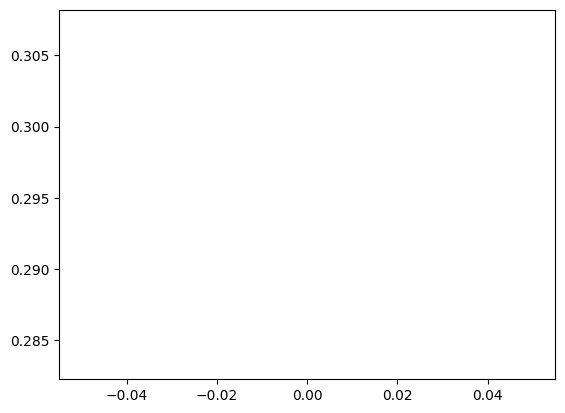

In [304]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(dim=0, keepdim=True))

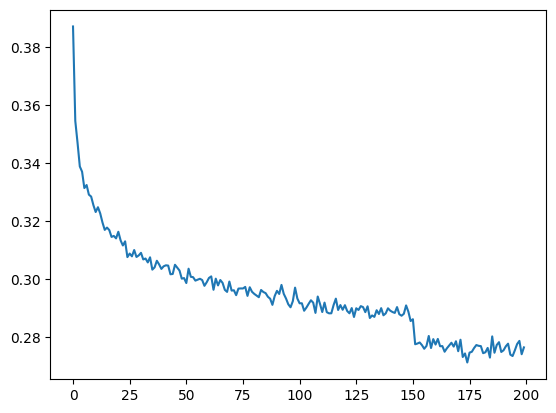

In [305]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(dim=1, keepdim=True))

In [306]:
for layer in model.layers:
    layer.training = False

In [307]:
#evaluate the loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    #emb = C[x] #(N, block_size, n_embd)
    #x = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embd)
    #for layer in layers:
    #    x = layer(x)
    x = model(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.8651373386383057
val 2.241358995437622


### Performance Log:
* original(3 character context + 200 hidden neurons, 12K params): train 2.01, val: 2.3
* context: 3 -> 8 (22K params): train 1.86 and val 2.24
* flat -> hierarchical(22K params): train 1.89 and val 2.25
* batchnorm1d bug fix: train 1.86 and val 2.24

In [308]:
#sample from model

for _ in range(20):#want to generate 20 samples

    out = []
    context = [0] * block_size #initialize with all ...
    while True:
        logits = model(torch.tensor(context).view(1,-1))
        #logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        #sample from the distribution
        #print(probs)
        ix = torch.multinomial(probs, num_samples=1).item()

        #shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        #if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itoc[i] for i in out))
        

lyren.
cheson.
brooklynn.
hajayra.
amilia.
sarah.
karine.
baylan.
reaghan.
adalynn.
asola.
alliah.
ezella.
tykic.
kayren.
kyelen.
sonavanna.
mikar.
kaysia.
korrianva.


Andrej ran this architecture with n_embd = 24 and n_hidden = 128 - with approximately 76K parameters and achieved a train loss = 1.77 and val loss of 1.99 - going below the barrier of 2.0 val loss!<br>
Let's us also try the same (it might take lots of time - since, there are 76K parameters now)

In [309]:
n_embd = 24
n_hidden = 128

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2),Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

#parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

####IMP STEP######
for p in parameters:
    p.requires_grad = True

76579


In [310]:
epochs = 200000
batch_size = 32
lossi = []

for i in range(epochs):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb = Xtr[ix]
    yb = Ytr[ix]

    logits = model(Xb)
    loss = F.cross_entropy(logits, yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update: simple SGD
    lr = 0.1 if i < 150000 else 0.01 #step learning rate decay
    for p in parameters:
            p.data += -lr * p.grad

    #track stats
    if i%10000 == 0: #print every once in a while
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    #break


      0/ 200000: 3.3003
  10000/ 200000: 2.1435
  20000/ 200000: 2.2487
  30000/ 200000: 2.2027
  40000/ 200000: 1.9483
  50000/ 200000: 1.7465
  60000/ 200000: 1.8596
  70000/ 200000: 1.7386
  80000/ 200000: 2.1052
  90000/ 200000: 1.7629
 100000/ 200000: 1.8437
 110000/ 200000: 1.7471
 120000/ 200000: 2.0115
 130000/ 200000: 2.0634
 140000/ 200000: 1.7503
 150000/ 200000: 1.6282
 160000/ 200000: 1.7994
 170000/ 200000: 1.8925
 180000/ 200000: 1.9256
 190000/ 200000: 1.5035


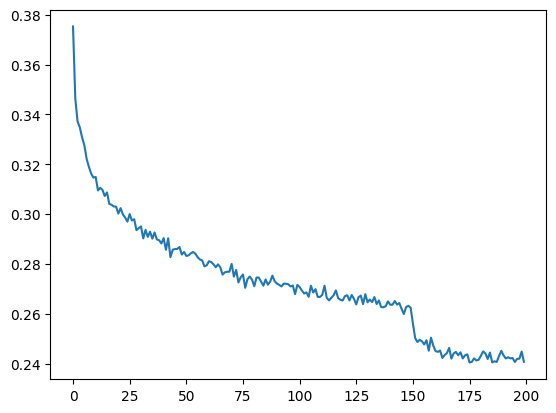

In [311]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(dim=1, keepdim=True))

In [312]:
for layer in model.layers:
    layer.training = False

In [313]:
#evaluate the loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    #emb = C[x] #(N, block_size, n_embd)
    #x = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embd)
    #for layer in layers:
    #    x = layer(x)
    x = model(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7252774238586426
val 2.234449625015259


### Performance Log:
* original(3 character context + 200 hidden neurons, 12K params): train 2.01, val: 2.3
* context: 3 -> 8 (22K params): train 1.86 and val 2.24
* flat -> hierarchical(22K params): train 1.89 and val 2.25
* batchnorm1d bug fix: train 1.86 and val 2.24
* n_embd = 24, n_hidden = 128: train 1.72 and val 2.23

In [315]:
split_loss('test')

test 2.2856523990631104


LOL!!

In [314]:
#sample from model

for _ in range(20):#want to generate 20 samples

    out = []
    context = [0] * block_size #initialize with all ...
    while True:
        logits = model(torch.tensor(context).view(1,-1))
        #logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        #sample from the distribution
        #print(probs)
        ix = torch.multinomial(probs, num_samples=1).item()

        #shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        #if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itoc[i] for i in out))
        

jainan.
yashi.
serenity.
arabell.
mailey.
kenzleigh.
anwale.
adelyne.
marvella.
zyrah.
john.
aina.
kyleah.
essie.
amala.
maryel.
camelea.
erplee.
liana.
janiyla.


With slow training (more parameters) we are out of experimental harness (being able to do multiple experiments and conclude better values for hyperparameters)!<br>

We haven't exactly implemented WaveNet, but a small component of it!

There's more to it - Residual and Skip connections wala full architecture!

![title](img/wavenet2.png)

## Step-by-Step Explanation of Dilated Convolutions in WaveNet

### 1. Relation to Convolutional Neural Networks (CNNs)
- Dilated convolutions, like those used in the **WaveNet** paper, relate to CNNs. 
- The key idea is that convolutions are used for **efficiency** and do not change the underlying model structure.

### 2. Independent Examples
- Consider the example of a name, "DeAndre," which has 7 letters.
- In the model, each letter is treated as an **independent example**. 
- Each row represents a separate example that the model processes one by one through forward passes (i.e., running inputs through the model to generate outputs).

### 3. Shape and Batch Dimension
- Inputs need to be formatted properly for model processing.
- For example, a 1D array must be converted into a 2D array with a batch size of 1 to avoid errors during forward passes. 
- This adds a "batch dimension" to the input, which is required for efficient processing.

### 4. For Loop Processing
- If you want to process all letters at once (i.e., all independent examples), you could use a **for loop** to process each one sequentially.
- However, this is inefficient as it involves making multiple independent calls to the model.

### 5. Efficiency Through Convolutions
- **Convolutions** allow us to avoid the for loop by **sliding a filter** over the input sequence. This greatly improves efficiency because:
  1. The entire sequence (e.g., "DeAndre") is processed at once, instead of processing each letter individually.
  2. The sliding operation happens inside optimized **CUDA kernels**, making the process faster and more efficient compared to processing in Python.

### 6. Convolution as a Sliding Window
- A convolution acts like a **sliding window**, moving across the input sequence (e.g., the letters of "DeAndre").
- This sliding window calculates outputs for all positions simultaneously, making the computation efficient.

### 7. Reusing Computation
- Convolutions enable **reusing previously computed values**. 
- For example, a node in the model can be reused as the right child for one node and the left child for another. 
- This avoids the need to **recompute values**, reducing redundant operations and improving efficiency.

### 8. Applying Filters
- In convolutions, the linear layers (layers that perform computations) are treated as **filters**.
- These filters are applied across the input sequence layer by layer, effectively sliding over the sequence.

### 9. Efficient Layer Processing
- Convolutions enable the efficient calculation of outputs for each layer:
  1. First, the convolution processes the first layer of the network.
  2. It then processes the second, third, and so on, until the output layer is reached.
- The entire process is optimized and handled efficiently thanks to convolutions.

### Summary
- The primary benefit of using **dilated convolutions** is **efficient sequential processing**. 
- Instead of manually looping through the input, convolutions allow the model to slide over the input sequence, reuse computations, and perform multiple operations at once.
- This structure is particularly beneficial for models like **WaveNet**, where long-range dependencies are crucial (e.g., for audio generation tasks).
